In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR_2D(in_ch, out_ch, k_size = 3, stride = 1, padding = 1, bias = True):
            layers =[]
            layers += [nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=k_size, stride=stride, padding=padding, bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_ch)]
            layers += [nn.ReLU()]

            conv_block = nn.Sequential(*layers)

            return conv_block

        self.encoder_layer_1_1 = CBR_2D(in_ch=3, out_ch=64) 
        self.encoder_layer_1_2 = CBR_2D(in_ch=64, out_ch=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.encoder_layer_2_1 = CBR_2D(in_ch=64, out_ch=128)
        self.encoder_layer_2_2 = CBR_2D(in_ch=128, out_ch=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.encoder_layer_3_1 = CBR_2D(in_ch=128, out_ch=256)
        self.encoder_layer_3_2 = CBR_2D(in_ch=256, out_ch=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.decoder_layer_4_2 = CBR_2D(in_ch=256, out_ch=512)
        self.decoder_layer_4_1 = CBR_2D(in_ch=512, out_ch=512)

        self.unpool3 = nn.ConvTranspose2d(in_channels=512, out_channels=256, \
                                        kernel_size=2, stride=2, padding=0, bias=True)
        
        self.decoder_layer_3_2 = CBR_2D(in_ch=512, out_ch=256)
        self.decoder_layer_3_1 = CBR_2D(in_ch=256, out_ch=256)


        self.unpool2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, \
                                        kernel_size=2, stride=2, padding=0, bias=True)

        self.decoder_layer_2_2 = CBR_2D(in_ch=256, out_ch=128)
        self.decoder_layer_2_1 = CBR_2D(in_ch=128, out_ch=128)

        self.unpool1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, \
                                        kernel_size=2, stride=2, padding=0, bias=True)

        self.decoder_layer_1_2 = CBR_2D(in_ch=128, out_ch=64)
        self.decoder_layer_1_1 = CBR_2D(in_ch=64, out_ch=64)
        self.conv1x1 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def forward(self, x):
        enc1_1 = self.encoder_layer_1_1(x)
        enc1_2 = self.encoder_layer_1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.encoder_layer_2_1(pool1)
        enc2_2 = self.encoder_layer_2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.encoder_layer_3_1(pool2)
        enc3_2 = self.encoder_layer_3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        bottom = self.decoder_layer_4_2(pool3)
        bottom = self.decoder_layer_4_1(bottom)
        unpool3 = torch.cat((self.unpool3(bottom), enc3_2), dim=1)

        dec3_2 = self.decoder_layer_3_2(unpool3)
        dec3_1 = self.decoder_layer_3_1(dec3_2)
        unpool2 = torch.cat((self.unpool2(dec3_1), enc2_2), dim=1)

        dec2_2 = self.decoder_layer_2_2(unpool2)
        dec2_1 = self.decoder_layer_2_1(dec2_2)
        unpool1 = torch.cat((self.unpool1(dec2_1), enc1_2), dim=1)

        dec1_2 = self.decoder_layer_1_2(unpool1)
        dec1_1 = self.decoder_layer_1_1(dec1_2)

        output = self.conv1x1(dec1_1)

        return output

In [21]:
import cv2
import numpy as np

class Dataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        data = os.listdir(self.data_dir)

        img_list, label_list = [], []
        for f in sorted(data):
            if 'sample' in f:
                img_list.append(f) 
            elif 'label' in f:
                label_list.append(f)

        self.img_list = img_list
        self.label_list = label_list

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, index):

        input = cv2.imread(os.path.join(self.data_dir, self.img_list[index]))
        label = cv2.imread(os.path.join(self.data_dir, self.label_list[index]), cv2.IMREAD_GRAYSCALE)

        input, label = input/255.0, label/255.0
        input, label = input.astype(np.float32), label.astype(np.float32)

        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        if self.transform:
            data = self.transform(data)

        return data

class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else cpu)

In [22]:
data_dir = '/mnt/hdd1/c-MET_datasets/Lung_c-MET IHC_scored/DL-based_tumor_seg_dataset'

transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])
dataset = Dataset(data_dir=os.path.join(data_dir, 'test'), transform = transform)
loader = DataLoader(dataset, batch_size = 10, shuffle = False)

In [23]:
net = UNet().to(device)
fn_loss = nn.BCEWithLogitsLoss().to(device)
optim = torch.optim.Adam(net.parameters(), lr = 1e-3)

In [7]:
''.join(filter(str.isdigit,'str_10'))

'10'

In [24]:
def load(ckpt_dir,net,optim):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        epoch = 0
        return net, optim, epoch
    
    ckpt_lst = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str.isdigit,f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net,optim,epoch

In [25]:

ckpt_dir = '/mnt/hdd1/model/Lung_c-MET IHC_scored/UNet/checkpoint'

net, optim, start_epoch = load(ckpt_dir = ckpt_dir, net = net, optim = optim) # 저장된 네트워크 불러오기

In [26]:
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std : (x*std) + mean
fn_classifier = lambda x : 1.0 * (x > 0.5)

outputs = []

with torch.no_grad(): # validation 이기 때문에 backpropa 진행 x, 학습된 네트워크가 정답과 얼마나 가까운지 loss만 계산
    net.eval() # 네트워크를 evaluation 용으로 선언
    loss_arr = []

    for batch, data in enumerate(loader,1):
        # forward
        label = data['label'].to(device)
        inputs = data['input'].to(device)
        output = net(inputs)

        # loss 
        loss = fn_loss(output,label)
        loss_arr += [loss.item()]

        output = fn_tonumpy(fn_classifier(output))
        outputs.append(output)
        
    print('test : Loss %.4f'%(np.mean(loss_arr)))

test : Loss 0.2155


In [27]:
len(dataset)

54

In [28]:
outputs = np.concatenate(outputs)
outputs.shape

(54, 256, 256, 1)

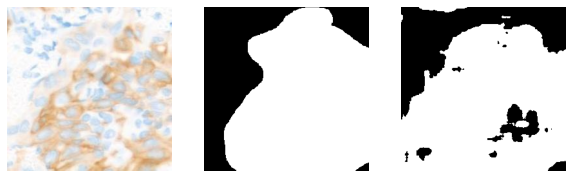

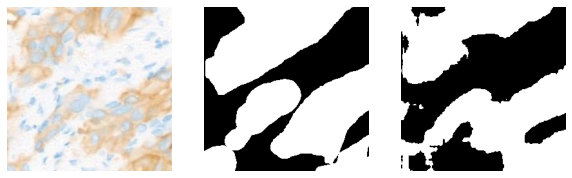

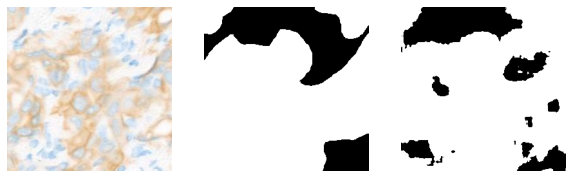

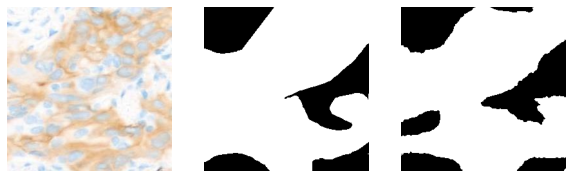

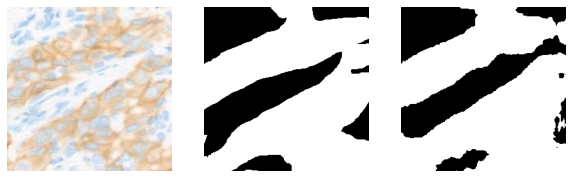

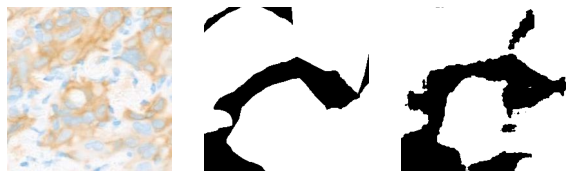

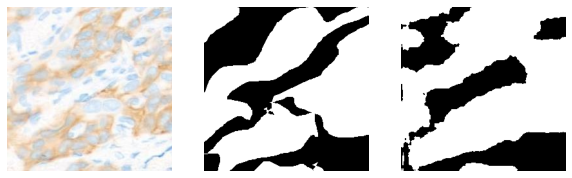

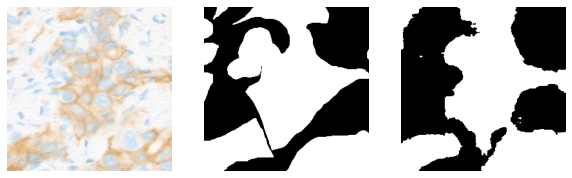

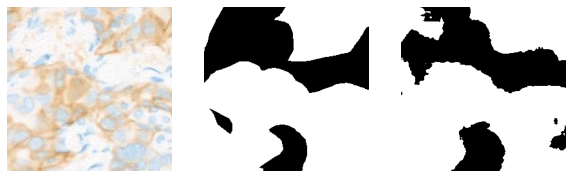

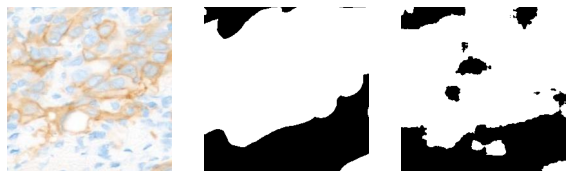

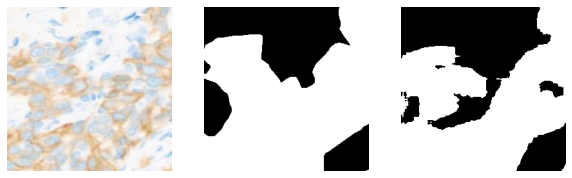

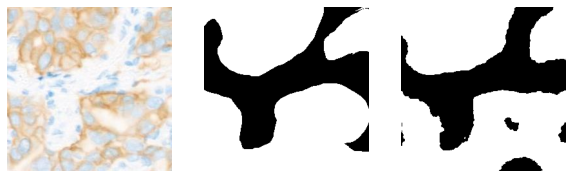

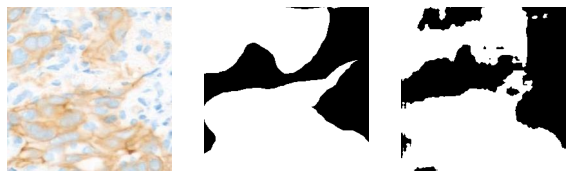

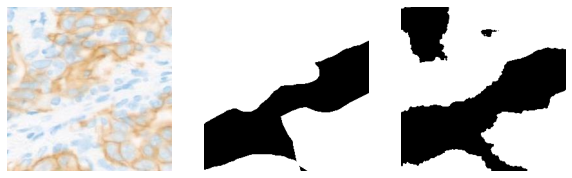

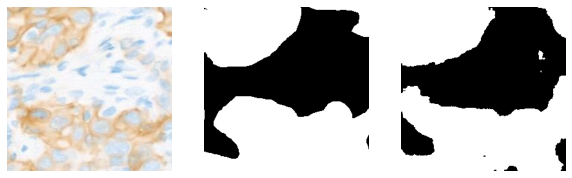

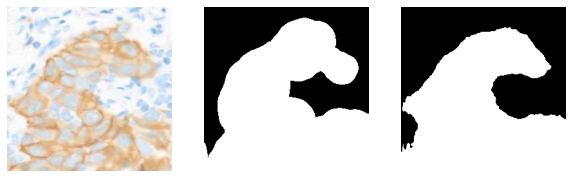

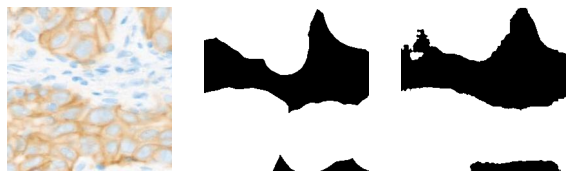

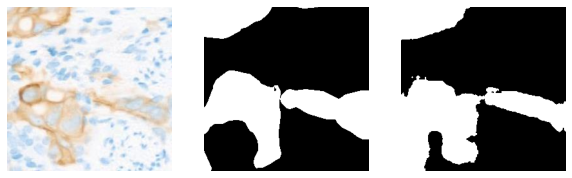

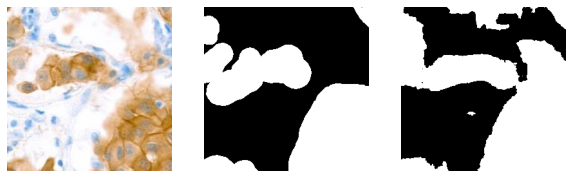

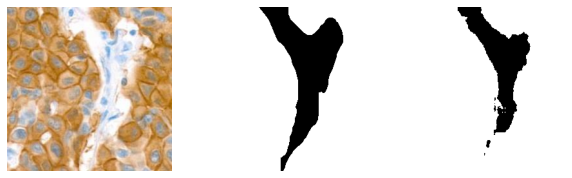

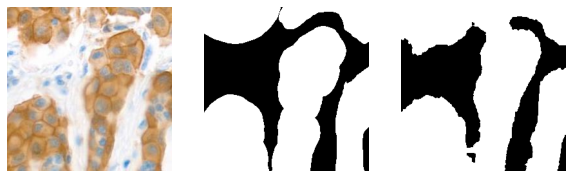

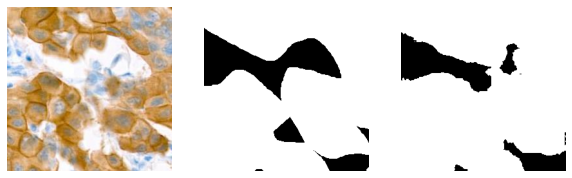

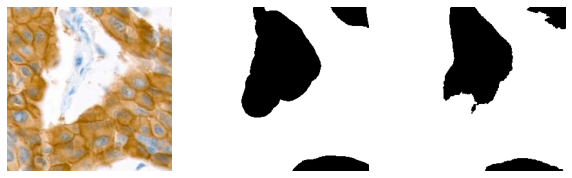

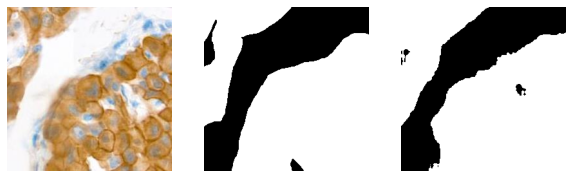

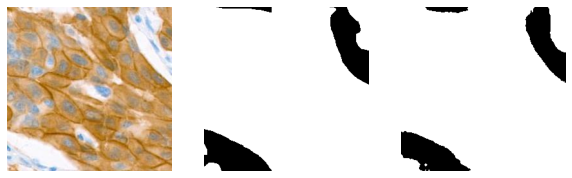

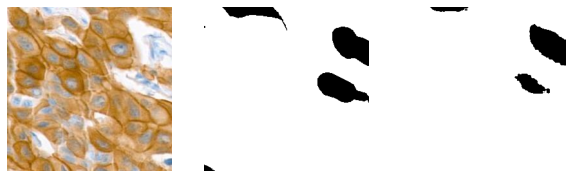

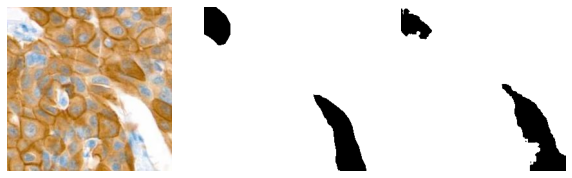

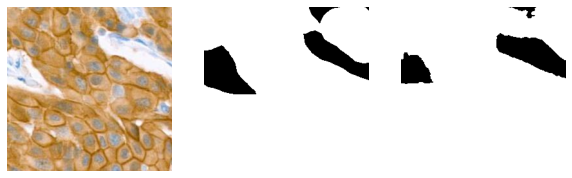

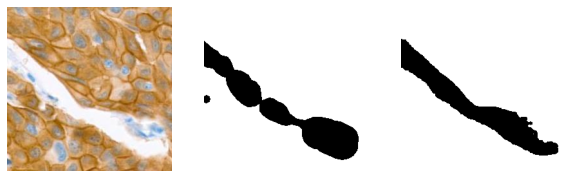

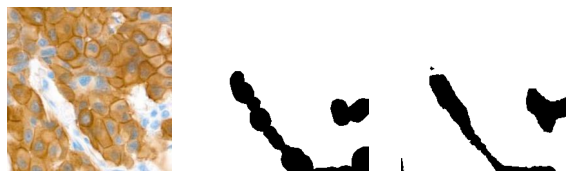

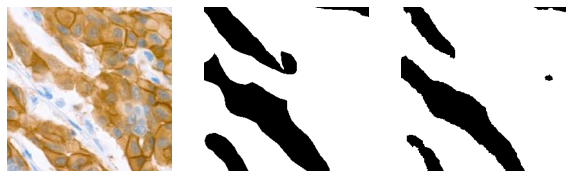

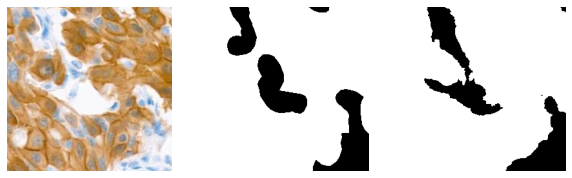

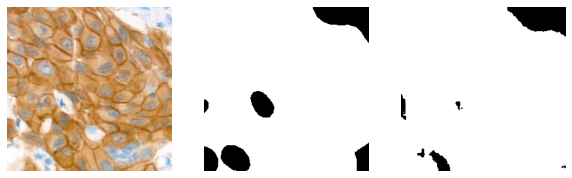

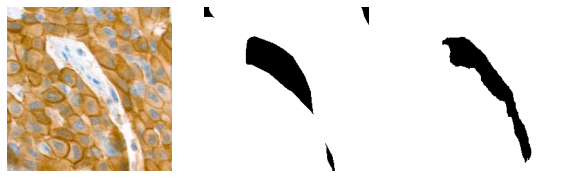

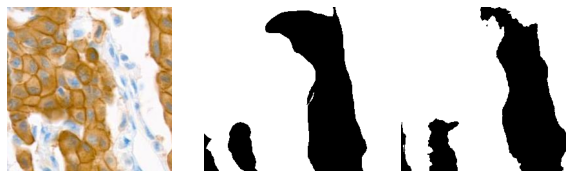

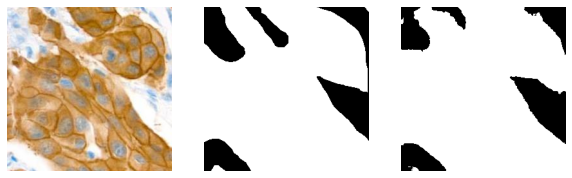

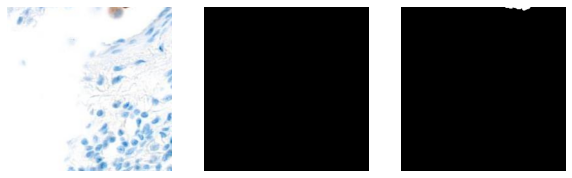

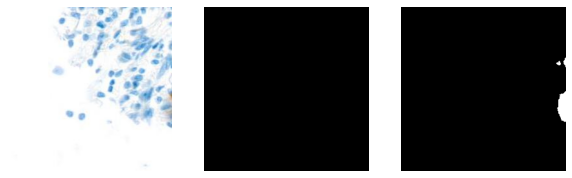

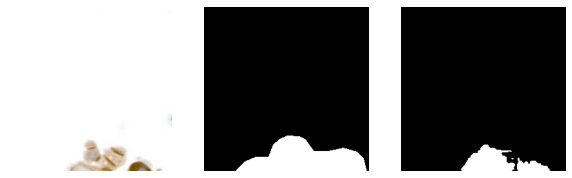

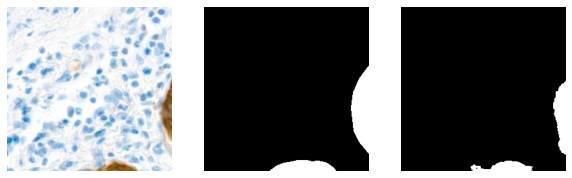

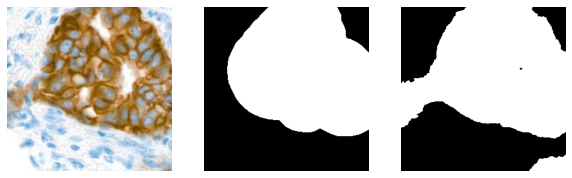

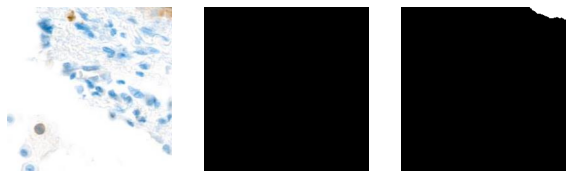

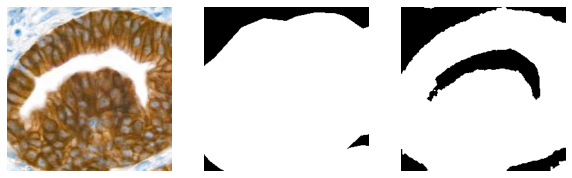

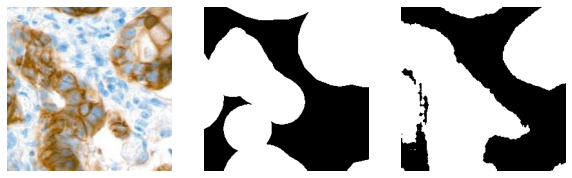

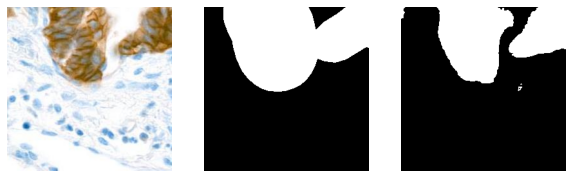

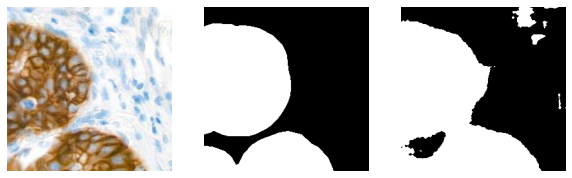

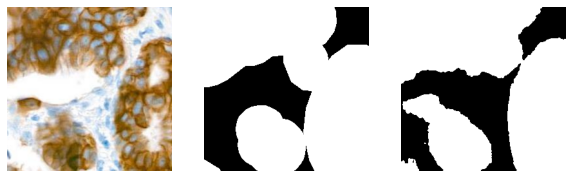

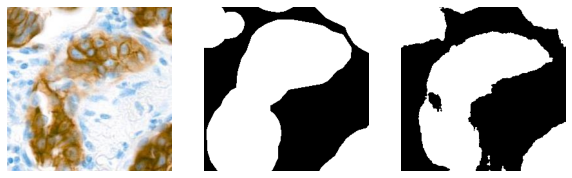

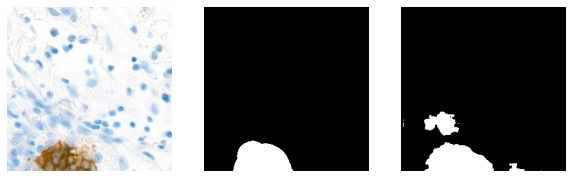

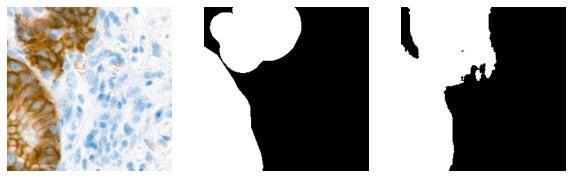

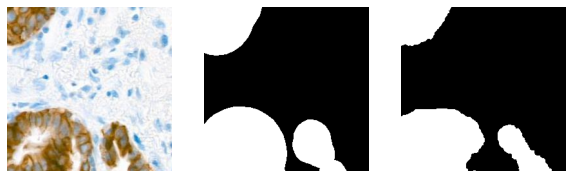

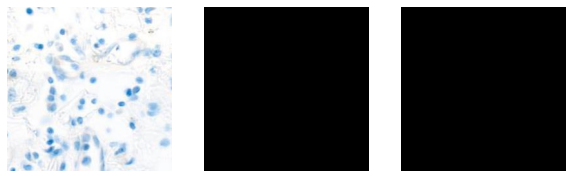

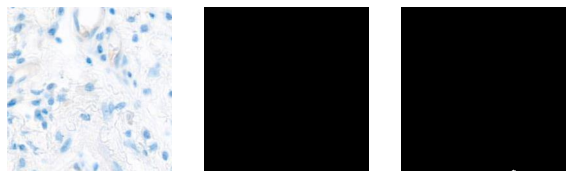

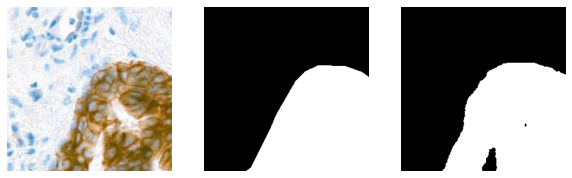

In [30]:
import matplotlib.pyplot as plt

for i in range(len(dataset)):
    data = dataset.__getitem__(i)
    img, label = data['input'], data['label']

    img = fn_denorm(img,0.5,0.5).detach().numpy().transpose(1, 2, 0)
    label = np.squeeze(label.detach().numpy().transpose(1, 2, 0))

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(label*255, cmap = 'gray', vmax=255,vmin=0)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(outputs[i]*255, cmap = 'gray', vmax=255,vmin=0)
    plt.axis('off')
    
    plt.show()


